In [23]:
import os 
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
def get_clip_info(clip: str) -> list:
    '''
    Returns info on clip. Assumes order of trick_firstname-lastname_sw_slow_mo
    ''' 
    sw = False
    slowmo = False

    clip = clip.split('/')[-1].split('\\')[-1].split('.')[0].split('_')
    trick = clip[0]
    skater = clip[1]
    if len(clip) > 2: 
        if clip[2] == 'sw':
            sw = True
        if clip[2] == 'slow-mo': 
            slowmo = True
        elif len(clip) > 3:
            if clip[3] == 'slow-mo':
                slowmo = True
            

    return [trick, skater, sw, slowmo]

In [34]:
tricks_path = "C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks/"
tricks_data = []

for clip in glob.glob(tricks_path + '/*'): 
#     print(clip)
#     print(get_clip_info(clip))
    entry = get_clip_info(clip)
    entry.append(clip)
    tricks_data.append(entry)      

tricks_data

[['360-flip',
  'akihiko-gatangay',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_akihiko-gatangay.mov'],
 ['360-flip',
  'andrew-reynolds',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_andrew-reynolds.mov'],
 ['360-flip',
  'antwuan-dixon',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_antwuan-dixon.mov'],
 ['360-flip',
  'braden-starcher',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_braden-starcher.mp4'],
 ['360-flip',
  'braden-starcher',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_braden-starcher_2.mp4'],
 ['360-flip',
  'hyun-kummer',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_hyun-kummer.mov'],
 ['360-flip',
  'maurio-mccoy',
  False,
  False,
  'C:/Users/Braden/Projects/SkateboardAI/skateboard-tricks\\360-flip_maurio-mccoy.mov'],

<BarContainer object of 5 artists>

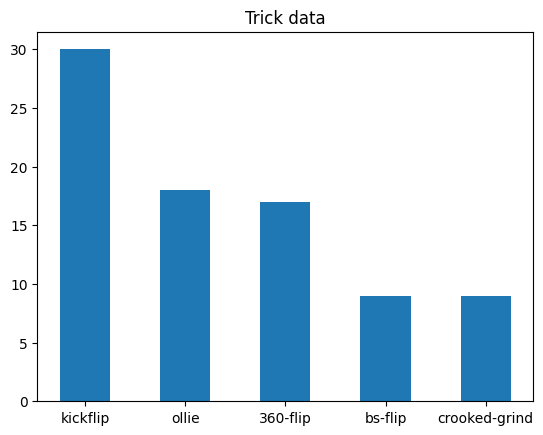

In [48]:
trick_names = ['360-flip', 'crooked-grind' 'bs-flip', 'kickflip','ollie']

tricks_df = pd.DataFrame(tricks_data)
tricks_df = tricks_df.rename(columns={0: 'trick', 1: 'skater', 2: 'switch', 3: 'slowmo', 4: 'filepath'})
# tricks_df
categories = tricks_df['trick'].value_counts().index
counts = tricks_df['trick'].value_counts().values
plt.title("Trick data")
plt.bar(categories, counts, width=0.5)


### SkateboardingDataset

In [11]:
import torch
from skimage import io, transform 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [49]:
import cv2

In [64]:
cap = cv2.VideoCapture('./skateboard-tricks/360-flip_andrew-reynolds.mov')

In [65]:
frames = 
while cap.isOpened(): 
    ret, frame = cap.read() 
    
    # if frame is read correctly ret is True 
    if not ret: 
        print("Can't receive frame (stream end?). Exiting...")
        break 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     print(str(sys.getsizeof(cap)))
#   plt.imshow(gray)

cap.release()

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
Can't receive frame (stream end?). Exiting...


In [62]:
import sys
cap
sys.getsizeof(cap)

32